In [ ]:
## Step 1: Simulating Edge-IoT Environment
from google.colab import drive

/tmp/ipython-input-1-1839966916.py:104: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  state_seq = torch.FloatTensor(state_seq).unsqueeze(0)


[Episode 1] Reward: -192.508 | Latency: 1.74 ms | Energy: 660.08 | Actor Loss: -561.370
[Episode 2] Reward: -163.518 | Latency: 0.71 ms | Energy: 764.64 | Actor Loss: -478.102
[Episode 3] Reward: -169.198 | Latency: 0.68 ms | Energy: 709.09 | Actor Loss: -307.546
[Episode 4] Reward: -156.406 | Latency: 0.68 ms | Energy: 788.85 | Actor Loss: -184.202
[Episode 5] Reward: -153.697 | Latency: 0.85 ms | Energy: 725.55 | Actor Loss: -165.923
[Episode 6] Reward: -181.019 | Latency: 0.90 ms | Energy: 795.51 | Actor Loss: -400.293
[Episode 7] Reward: -152.484 | Latency: 0.71 ms | Energy: 673.09 | Actor Loss: -189.804
[Episode 8] Reward: -128.037 | Latency: 0.68 ms | Energy: 743.86 | Actor Loss: -90.533
[Episode 9] Reward: -130.091 | Latency: 0.72 ms | Energy: 678.99 | Actor Loss: -13.734
[Episode 10] Reward: -149.016 | Latency: 0.70 ms | Energy: 772.34 | Actor Loss: -93.826
[Episode 11] Reward: -139.368 | Latency: 0.67 ms | Energy: 758.08 | Actor Loss: -45.687
[Episode 12] Reward: -138.111 | La

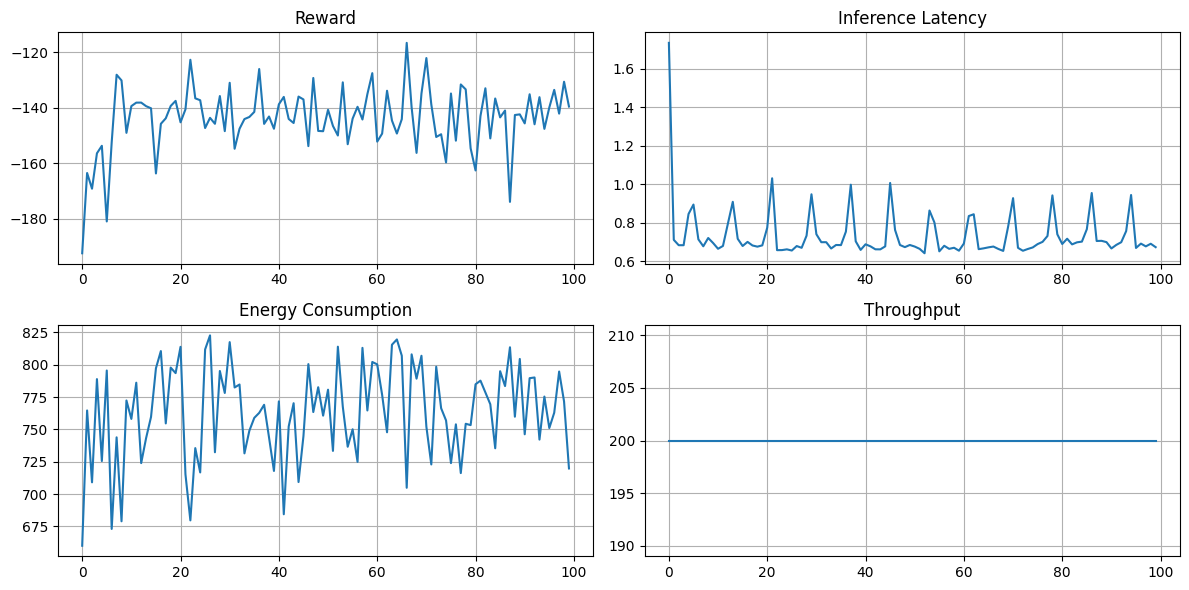

In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# ==================== Edge IoT Environment ==================== #
class EdgeIoTEnv:
    def __init__(self, num_agents=4):
        self.num_agents = num_agents
        self.max_steps = 50
        self.device_capacities = np.random.uniform(1.5, 3.5, size=num_agents)
        self.base_energy_cost = 0.2
        self.reset()

    def reset(self):
        self.step_count = 0
        self.state = self._generate_state()
        return self.state

    def _generate_state(self):
        state = []
        for _ in range(self.num_agents):
            task_size = np.random.uniform(5, 50)
            compute_req = np.random.uniform(0.5, 2.5)
            priority = np.random.uniform(0.1, 1.0)
            bandwidth = np.random.uniform(5, 100)
            state.append([task_size, compute_req, priority, bandwidth])
        return state

    def step(self, actions):
        rewards, energies = [], []
        self.step_count += 1
        done = self.step_count >= self.max_steps

        for i, action in enumerate(actions):
            task_size, compute_req, priority, bandwidth = self.state[i]
            capacity = self.device_capacities[i]

            latency = (task_size * 8) / bandwidth + np.random.uniform(1, 5)
            energy = min(compute_req / capacity, 1.0) * task_size * self.base_energy_cost

            if action == 0:
                latency *= 0.6
                energy *= 1.2
            elif action == 1:
                latency *= 1.5
                energy *= 0.8

            reward = priority * (-(0.6 * latency + 0.4 * energy))
            rewards.append(reward)
            energies.append(energy)

        next_state = self._generate_state()
        self.state = next_state
        return next_state, rewards, energies, done

# ==================== Attention Module ==================== #
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        weights = torch.softmax(self.attn(x), dim=1)
        return (x * weights).sum(dim=1)

# ==================== Actor-Critic Network ==================== #
class ActorCritic(nn.Module):
    def __init__(self, input_dim, hidden_dim, action_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.attn = Attention(hidden_dim)
        self.actor = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Linear(32, action_dim),
            nn.Softmax(dim=-1)
        )
        self.critic = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        context = self.attn(lstm_out)
        policy = self.actor(context)
        value = self.critic(context)
        return policy, value

# ==================== Agent ==================== #
class Agent:
    def __init__(self, input_dim, hidden_dim, action_dim, lr):
        self.model = ActorCritic(input_dim, hidden_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.gamma = 0.99

    def get_action(self, state_seq):
        state_seq = torch.FloatTensor(state_seq).unsqueeze(0)
        start_time = time.time()
        probs, _ = self.model(state_seq)
        latency = (time.time() - start_time) * 1000  # ms
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action), dist.entropy(), latency

    def update(self, state_seq, reward, log_prob, value, next_value):
        advantage = reward + self.gamma * next_value - value
        actor_loss = -log_prob * advantage.detach()
        critic_loss = advantage.pow(2)
        return actor_loss + critic_loss, actor_loss.item(), critic_loss.item()

# ==================== Federated Averaging ==================== #
def federated_avg(agent_list):
    global_dict = agent_list[0].model.state_dict()
    for key in global_dict.keys():
        global_dict[key] = torch.stack([agent.model.state_dict()[key].float() for agent in agent_list], dim=0).mean(dim=0)
    for agent in agent_list:
        agent.model.load_state_dict(global_dict)

# ==================== Training Loop ==================== #
def train_federated_marl():
    num_agents = 4
    input_dim = 4
    hidden_dim = 64
    action_dim = 2
    lr = 1e-3
    episodes = 100
    sequence_len = 5
    sync_every = 5

    env = EdgeIoTEnv(num_agents)
    agents = [Agent(input_dim, hidden_dim, action_dim, lr) for _ in range(num_agents)]
    buffers = [deque(maxlen=sequence_len) for _ in range(num_agents)]

    reward_log, actor_loss_log, critic_loss_log, entropy_log = [], [], [], []
    latency_log, energy_log, throughput_log = [], [], []

    for ep in range(episodes):
        state = env.reset()
        for buf in buffers:
            buf.clear()
            for _ in range(sequence_len):
                buf.append(np.zeros(input_dim))

        done = False
        ep_rewards = np.zeros(num_agents)
        total_actor_loss = 0
        total_critic_loss = 0
        total_entropy = 0
        total_latency = 0
        total_energy = 0

        while not done:
            for i in range(num_agents):
                buffers[i].append(state[i])

            actions, log_probs, values, entropies, latencies = [], [], [], [], []
            for i in range(num_agents):
                state_seq = list(buffers[i])
                action, log_prob, entropy, latency = agents[i].get_action(state_seq)
                _, value = agents[i].model(torch.FloatTensor(state_seq).unsqueeze(0))
                actions.append(action)
                log_probs.append(log_prob)
                values.append(value)
                entropies.append(entropy)
                latencies.append(latency)

            next_state, rewards, energies, done = env.step(actions)
            for i in range(num_agents):
                ep_rewards[i] += rewards[i]
                total_energy += energies[i]
                state_seq = list(buffers[i])
                _, next_value = agents[i].model(torch.FloatTensor(state_seq).unsqueeze(0))
                loss, a_loss, c_loss = agents[i].update(
                    state_seq,
                    torch.tensor(rewards[i], dtype=torch.float32),
                    log_probs[i], values[i], next_value
                )
                agents[i].optimizer.zero_grad()
                loss.backward()
                agents[i].optimizer.step()
                total_actor_loss += a_loss
                total_critic_loss += c_loss
                total_entropy += entropies[i].mean().item()
                total_latency += latencies[i]

            state = next_state

        if (ep + 1) % sync_every == 0:
            federated_avg(agents)

        reward_log.append(ep_rewards.mean())
        actor_loss_log.append(total_actor_loss / num_agents)
        critic_loss_log.append(total_critic_loss / num_agents)
        entropy_log.append(total_entropy / num_agents)
        latency_log.append(total_latency / (env.max_steps * num_agents))
        energy_log.append(total_energy)
        throughput_log.append(num_agents * env.max_steps)

        print(f"[Episode {ep+1}] Reward: {ep_rewards.mean():.3f} | Latency: {latency_log[-1]:.2f} ms | Energy: {total_energy:.2f} | Actor Loss: {total_actor_loss:.3f}")

    # Save metrics
    np.save("reward_log.npy", reward_log)
    np.save("latency_log.npy", latency_log)
    np.save("energy_log.npy", energy_log)
    np.save("throughput_log.npy", throughput_log)

    # Plot all metrics
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 2, 1)
    plt.plot(reward_log, label="Avg Reward")
    plt.title("Reward")
    plt.grid()
    plt.subplot(2, 2, 2)
    plt.plot(latency_log, label="Avg Latency (ms)")
    plt.title("Inference Latency")
    plt.grid()
    plt.subplot(2, 2, 3)
    plt.plot(energy_log, label="Total Energy")
    plt.title("Energy Consumption")
    plt.grid()
    plt.subplot(2, 2, 4)
    plt.plot(throughput_log, label="Throughput")
    plt.title("Throughput")
    plt.grid()
    plt.tight_layout()
    plt.show()

train_federated_marl()


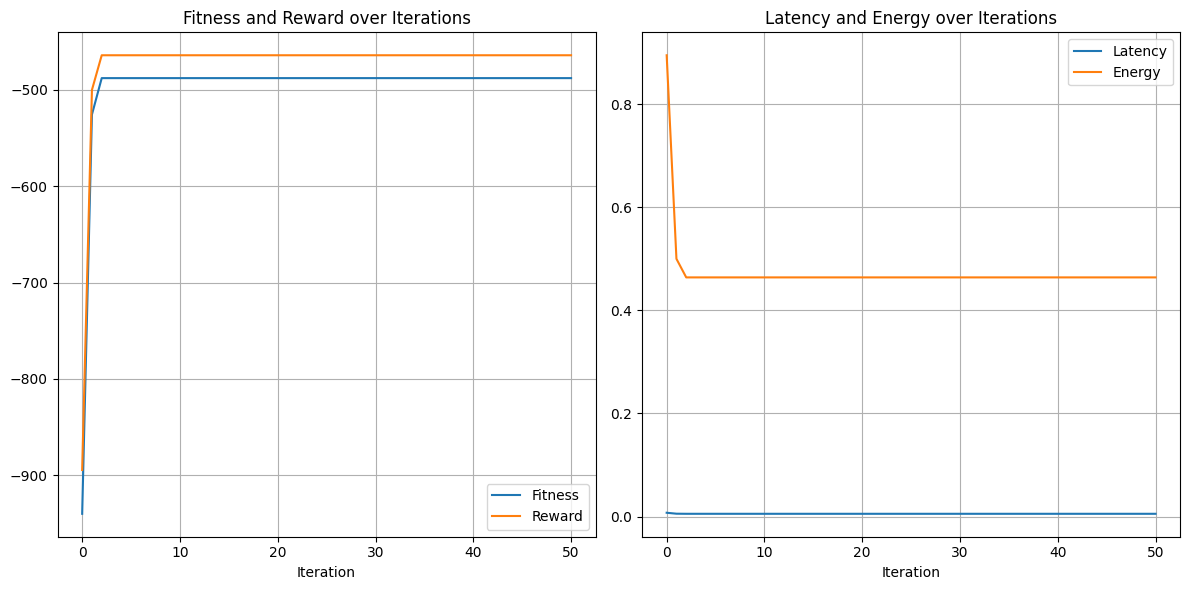

{'Final Fitness': np.float64(-487.6796224053801),
 'Final Reward': np.float64(-463.93487638624555),
 'Final Latency': np.float64(0.0054800219982225964),
 'Final Energy': np.float64(0.46393487638624553)}

In [ ]:
import numpy as np
import copy
import matplotlib.pyplot as plt

# ---------- RSO Parameters ----------
num_rats = 5               # Number of agents (rats)
max_iter = 50              # RSO iterations
alpha = 0.6                # Exploitation factor
beta = 0.4                 # Exploration factor
dim = 1000                 # Flattened model parameter dimension (example)

# ---------- Dummy Agent Weights (Replace with actual model weights) ----------
def generate_dummy_agent_weights(num_rats, dim):
    return [np.random.randn(dim) for _ in range(num_rats)]

# ---------- Simulated Performance Metrics (Latency, Energy, Reward) ----------
def simulate_latency(weights):
    return np.mean(np.abs(weights)) * 0.01  # Simulated latency (lower is better)

def simulate_energy_consumption(weights):
    return np.sum(np.square(weights)) * 0.001  # Simulated energy (lower is better)

def simulate_reward(weights):
    return -np.sum(weights ** 2)  # Simulated reward (higher is better)

# ---------- Fitness Function Combining Metrics ----------
def fitness(weights):
    reward = simulate_reward(weights)
    latency = simulate_latency(weights)
    energy = simulate_energy_consumption(weights)
    return reward + (-latency * 100) + (-energy * 50)  # Weighted penalty

# ---------- RSO Optimization Function ----------
def rat_swarm_optimization(agent_weights, max_iter=50, alpha=0.6, beta=0.4):
    num_rats = len(agent_weights)
    dim = len(agent_weights[0])

    rats = copy.deepcopy(agent_weights)
    fitness_vals = [fitness(r) for r in rats]
    best_idx = np.argmax(fitness_vals)
    global_best = rats[best_idx]
    global_best_fitness = fitness_vals[best_idx]

    fitness_history = [global_best_fitness]
    latency_history = [simulate_latency(global_best)]
    energy_history = [simulate_energy_consumption(global_best)]
    reward_history = [simulate_reward(global_best)]

    for t in range(max_iter):
        for i in range(num_rats):
            rand_vec = np.random.uniform(-1, 1, dim)
            step = alpha * (global_best - rats[i]) + beta * rand_vec
            rats[i] = rats[i] + step

        fitness_vals = [fitness(r) for r in rats]
        best_idx = np.argmax(fitness_vals)
        if fitness_vals[best_idx] > global_best_fitness:
            global_best = rats[best_idx]
            global_best_fitness = fitness_vals[best_idx]

        fitness_history.append(global_best_fitness)
        latency_history.append(simulate_latency(global_best))
        energy_history.append(simulate_energy_consumption(global_best))
        reward_history.append(simulate_reward(global_best))

    return global_best, fitness_history, latency_history, energy_history, reward_history

# ---------- Execute RSO ----------
agent_weights = generate_dummy_agent_weights(num_rats, dim)
optimized_weights, fitness_track, latency_track, energy_track, reward_track = rat_swarm_optimization(agent_weights, max_iter, alpha, beta)

# ---------- Output & Plot ----------
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fitness_track, label="Fitness")
plt.plot(reward_track, label="Reward")
plt.title("Fitness and Reward over Iterations")
plt.xlabel("Iteration")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(latency_track, label="Latency")
plt.plot(energy_track, label="Energy")
plt.title("Latency and Energy over Iterations")
plt.xlabel("Iteration")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

{
    "Final Fitness": fitness_track[-1],
    "Final Reward": reward_track[-1],
    "Final Latency": latency_track[-1],
    "Final Energy": energy_track[-1]
}

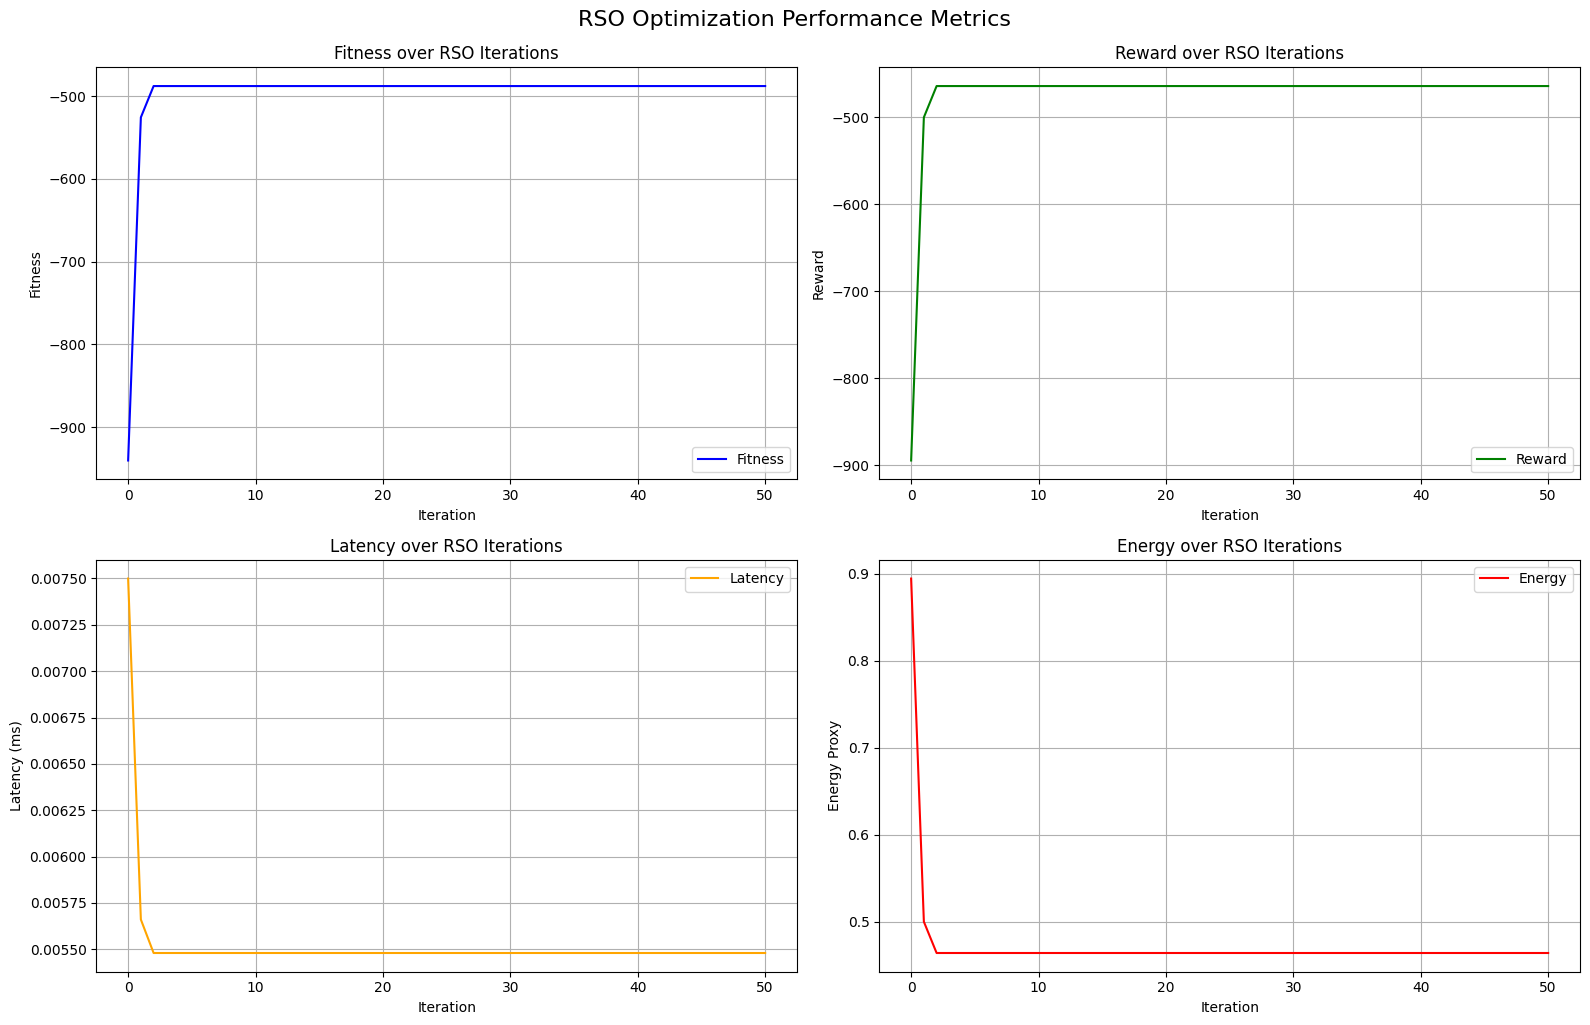

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# These arrays must be returned from your RSO run
# If running in Google Colab, just use these directly after running the optimizer:
# optimized_weights, fitness_track, latency_track, energy_track, reward_track

# Plot all RSO-related performance metrics
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.plot(fitness_track, label="Fitness", color="blue")
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.title("Fitness over RSO Iterations")
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(reward_track, label="Reward", color="green")
plt.xlabel("Iteration")
plt.ylabel("Reward")
plt.title("Reward over RSO Iterations")
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(latency_track, label="Latency", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Latency (ms)")
plt.title("Latency over RSO Iterations")
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(energy_track, label="Energy", color="red")
plt.xlabel("Iteration")
plt.ylabel("Energy Proxy")
plt.title("Energy over RSO Iterations")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.suptitle("RSO Optimization Performance Metrics", fontsize=16, y=1.02)
plt.show()
